In [22]:
import pandas as pd
from missingno import matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
df = pd.read_csv(r'/home/drumyr/Downloads/bank_transactions.csv')

In [5]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [6]:
df = df[['TransactionAmount (INR)','TransactionDate','CustAccountBalance','CustomerID','TransactionID']]
df = df.astype({'CustomerID':'category','TransactionID':'category'})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

<AxesSubplot:>

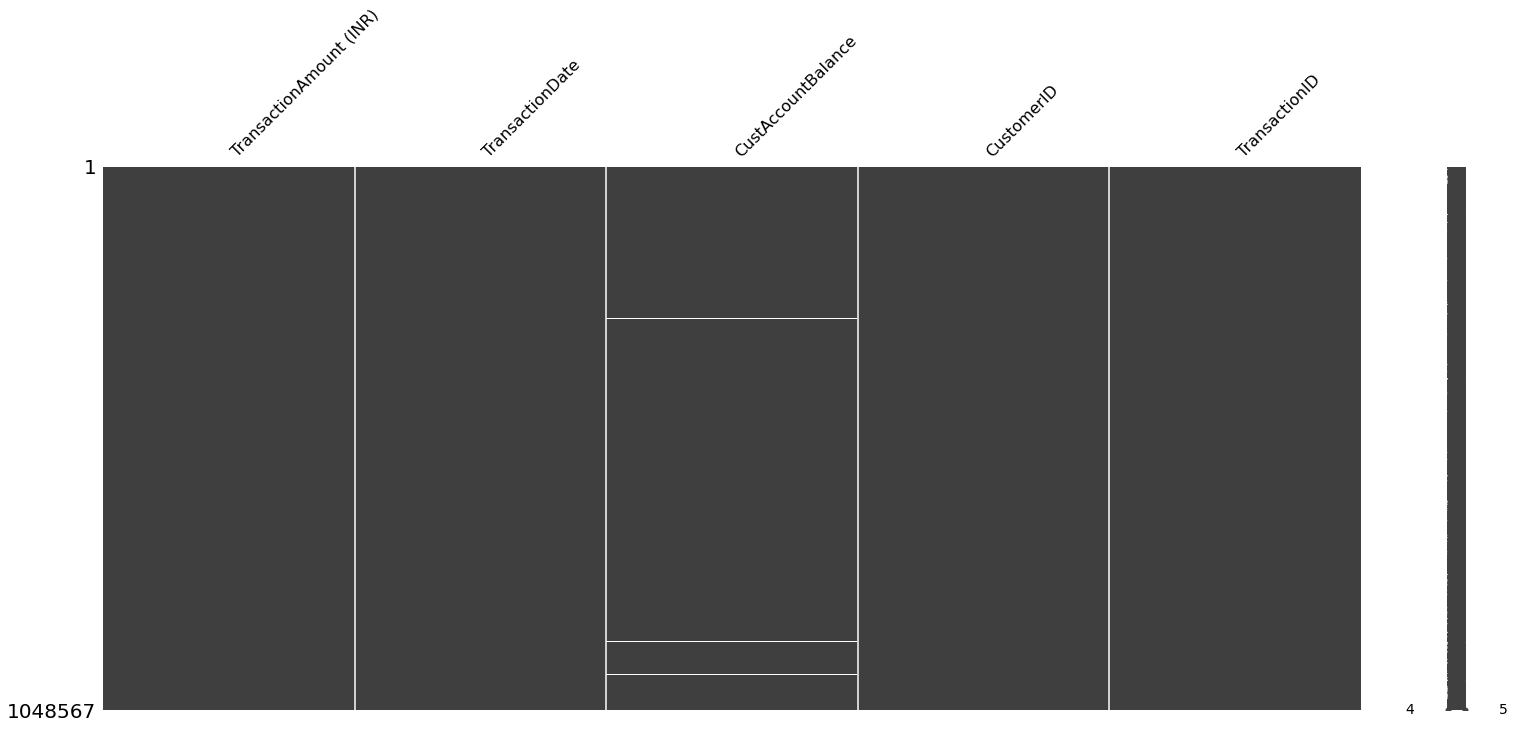

In [7]:
matrix(df)

In [8]:
df = df.dropna().drop_duplicates(subset=['TransactionID'])
df.shape

(1046198, 5)

In [10]:
df1 = df.copy(deep=True)
df1 = df1.dropna()

here we create a new RECENCY variable,making it time after the last transaction in months(days do not matter for us overall in this exploration,for we look into regularity over too big time period

In [11]:
df1['lastday'] = df1['TransactionDate'].max()
df1['last_transaction_date'] = df1.groupby('CustomerID')['TransactionDate'].transform('max')
df1['RECENCY'] = (((df1['lastday']-df1['last_transaction_date']) / pd.Timedelta(days=1) )/30).round(0)

frequency variable,that will be overall number of transactions

In [12]:
df1['FREQUENCY'] = df1.groupby('CustomerID')['TransactionID'].transform('size')

monetary value for each customer will be the total amount of transaction(overall distribution in dataset,but monetary value for each customer is highly correlated with it's mean value)

In [13]:
df1['MONETARY'] = df1.groupby('CustomerID')['TransactionAmount (INR)'].transform('sum')

I have also decided to divide customers according to their balance(using common customer division in banking,based on their net worth.By the way I have also created a continuous variable for balance in order to check for it's colinearity with monetary customer value).This division was made in order to prepare customers' data for further analysis in the matter of credit scoring and perhaps survival analysis

In [14]:
df1['BALANCE'] = df1.groupby('CustomerID')['CustAccountBalance'].transform('mean')
bins = [0, 10000, 100000, 1000000, float('inf')]
labels = ['Mass-market', 'Mass-affluent', 'High-net-worth', 'Corporate']
df1['BALANCE_CATEGORY'] = pd.cut(df1['BALANCE'], bins=bins, labels=labels)

In [15]:
df1= df1.drop(['last_transaction_date','lastday','CustAccountBalance','TransactionDate','TransactionID','TransactionAmount (INR)','CustomerID'],axis=1).drop_duplicates()

as planned,RFM dataset is quite non-colinear(except for balance features,but we will leave both of them because they have different purposes)

In [16]:
df1.corr()

/tmp/ipykernel_4549/1707261694.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df1.corr()


,RECENCY,FREQUENCY,MONETARY,BALANCE
RECENCY,1.000000,-0.215420,-0.020956,-0.002708
FREQUENCY,-0.215420,1.000000,0.102144,-0.000283
MONETARY,-0.020956,0.102144,1.000000,0.058865
BALANCE,-0.002708,-0.000283,0.058865,1.000000


In [20]:
df1.describe()

,RECENCY,FREQUENCY,MONETARY,BALANCE
count,835562.000000,835562.000000,8.355620e+05,8.355620e+05
mean,4.290826,1.195784,1.873618e+03,1.172742e+05
std,2.644945,0.460334,7.098805e+03,8.148770e+05
min,0.000000,1.000000,0.000000e+00,0.000000e+00
25%,3.000000,1.000000,2.000000e+02,5.799240e+03
50%,4.000000,1.000000,5.700000e+02,1.922137e+04
75%,5.000000,1.000000,1.551015e+03,6.319979e+04
max,11.000000,6.000000,1.560035e+06,1.150355e+08


We do not scale our data.It is not planned to use it for clustering model right now,thus it can introduce visual biase.

In [17]:
df = df1

as expected,monetary value of customers does has extreme outliers.However,due to data being anonimous,we can not check these customers,thus treationg them as valid data points.However,I did anticipated it and checked for unrealistic values(for example transaction amount being over a billion)

<AxesSubplot:xlabel='MONETARY', ylabel='Density'>

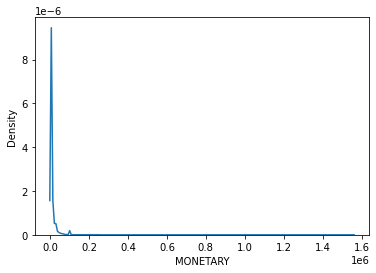

In [23]:
sns.kdeplot(df['MONETARY'])

In [28]:
df['FREQUENCY'] = df['FREQUENCY'].astype('int')
df['RECENCY'] = df['RECENCY'].astype('int')

as was expected,frequency distribution is extremely skewed.Also on this plot we can clearly see that corporate customers mostly rely on one-time contracts.Also,we do not make conclusions for highest categories,due to really high chance error.Howver it is a great way to see that customer churn is a problem between mass-affluent customers.

<AxesSubplot:xlabel='FREQUENCY', ylabel='BALANCE'>

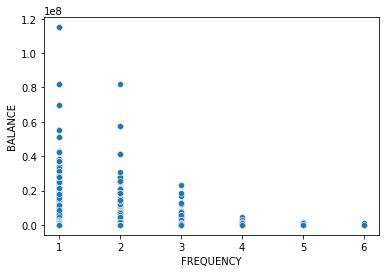

In [31]:
sns.scatterplot(x=df['FREQUENCY'],y=df['BALANCE'])

([<matplotlib.patches.Wedge at 0x7ffacc0af3d0>,
 [Text(0.5061364448923521, 0.9766401072819666, ''),
  Text(-0.9534515779616685, -0.5485709511835316, ''),
  Text(0.8901247362364224, -0.6462800893885248, ''),
  Text(1.0981860049217345, -0.06314664356907838, '')])

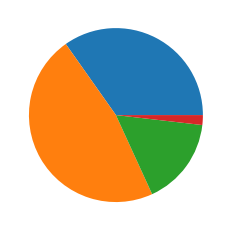

In [44]:
plt.pie(x=df.groupby('BALANCE_CATEGORY').size())

here we can see more clear distribution of customer categories between different frequencies.Assumptions about churn distributions were proven to be right

In [26]:
freq_counts = df.groupby(['FREQUENCY', 'BALANCE_CATEGORY']).size()
print(freq_counts)

FREQUENCY  BALANCE_CATEGORY
1          Mass-market         258967
           Mass-affluent       311277
           High-net-worth      107823
           Corporate            13051
2          Mass-market          28530
           Mass-affluent        69784
           High-net-worth       24265
           Corporate             1945
3          Mass-market           2457
           Mass-affluent        10265
           High-net-worth        3722
           Corporate              229
4          Mass-market            162
           Mass-affluent         1108
           High-net-worth         396
           Corporate               23
5          Mass-market             10
           Mass-affluent           95
           High-net-worth          37
           Corporate                3
6          Mass-market              0
           Mass-affluent           11
           High-net-worth           3
           Corporate                0
dtype: int64


Here we can see that data follows quite a visible curve.Howewer there are some outliers/valid points.The most expected reason for customers with extremely low financial velocity could be using this account as a reserve fund.Those with extremely high-perhaps fast growing firms with risky financial politics.Obviously situation could be really different,however data is restricted in time thus making impossible to check the whole customer history

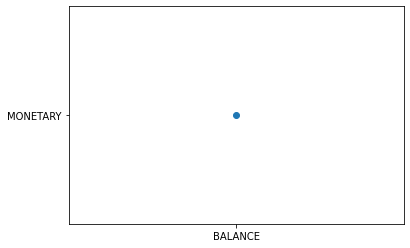

In [46]:
sns.scatterplot(x=df['BALANCE'],y=df['MONETARY'])